# LSTM

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

# Load Data

In [2]:
df = pd.read_csv('aggregate_data_hourly.csv')
df1 = df['close']
df1

0        131351.241429
1        131329.062167
2        130994.521000
3        131081.648333
4        131375.910333
             ...      
12336    259652.233636
12337    258618.822500
12338    258738.966667
12339    260985.861111
12340    260725.736667
Name: close, Length: 12341, dtype: float64

In [3]:
df1_max = max(df['close'])
df1_min = min(df['close'])

# Data Preprocessing

In [4]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
training_size=int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [6]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

# Train/Test Split

In [7]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_train2, y_train2 = X_train, y_train
X_test, y_test = create_dataset(test_data, time_step)
X_test2, y_test2 = X_test, y_test

In [8]:
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [9]:
X_train.shape[1]

100

# Model

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, activation = 'relu', return_sequences = True,  input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-traina

In [12]:
model.fit(X_train, y_train, epochs=20, batch_size=64, shuffle=False)

Epoch 1/20
153/153 [==============================] - 47s 288ms/step - loss: 0.0052
Epoch 2/20
153/153 [==============================] - 42s 271ms/step - loss: 0.0089
Epoch 3/20
153/153 [==============================] - 41s 268ms/step - loss: 0.0089
Epoch 4/20
153/153 [==============================] - 41s 268ms/step - loss: 0.0099
Epoch 5/20
153/153 [==============================] - 41s 270ms/step - loss: 0.0078
Epoch 6/20
153/153 [==============================] - 41s 268ms/step - loss: 0.0133
Epoch 7/20
153/153 [==============================] - 42s 273ms/step - loss: 0.0068
Epoch 8/20
153/153 [==============================] - 41s 268ms/step - loss: 0.0019
Epoch 9/20
153/153 [==============================] - 41s 267ms/step - loss: 0.0015
Epoch 10/20
153/153 [==============================] - 41s 267ms/step - loss: 6.8976e-04
Epoch 11/20
153/153 [==============================] - 41s 269ms/step - loss: 5.2060e-04
Epoch 12/20
153/153 [==============================] - 40s 264ms/s

# Prediction

In [13]:
test_predict = model.predict(X_test)

74/74 [==============================] - 6s 63ms/step


In [14]:
print(f'MSE {mean_squared_error(y_test, test_predict)}')
print(f'R2 {r2_score(y_test, test_predict)}')

MSE 0.0090772660653118
R2 -0.6424482823558859


In [15]:
test_predict= scaler.inverse_transform(test_predict)
train_predict = model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)

306/306 [==============================] - 21s 63ms/step


In [16]:
train_predict

array([[141317.44],
       [141288.61],
       [141246.  ],
       ...,
       [241300.3 ],
       [241360.48],
       [241412.42]], dtype=float32)

In [17]:
y_test2 = (y_test * (df1_max - df1_min)) + df1_min
y_test2

array([230781.1612069 , 231358.0525    , 231199.06052632, ...,
       258618.8225    , 258738.96666667, 260985.86111111])

In [18]:
print(f'MSE {mean_squared_error(y_test2, test_predict)}')
print(f'R2 {r2_score(y_test2, test_predict)}')

MSE 265651992.27787027
R2 -0.6424478400015063


In [19]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

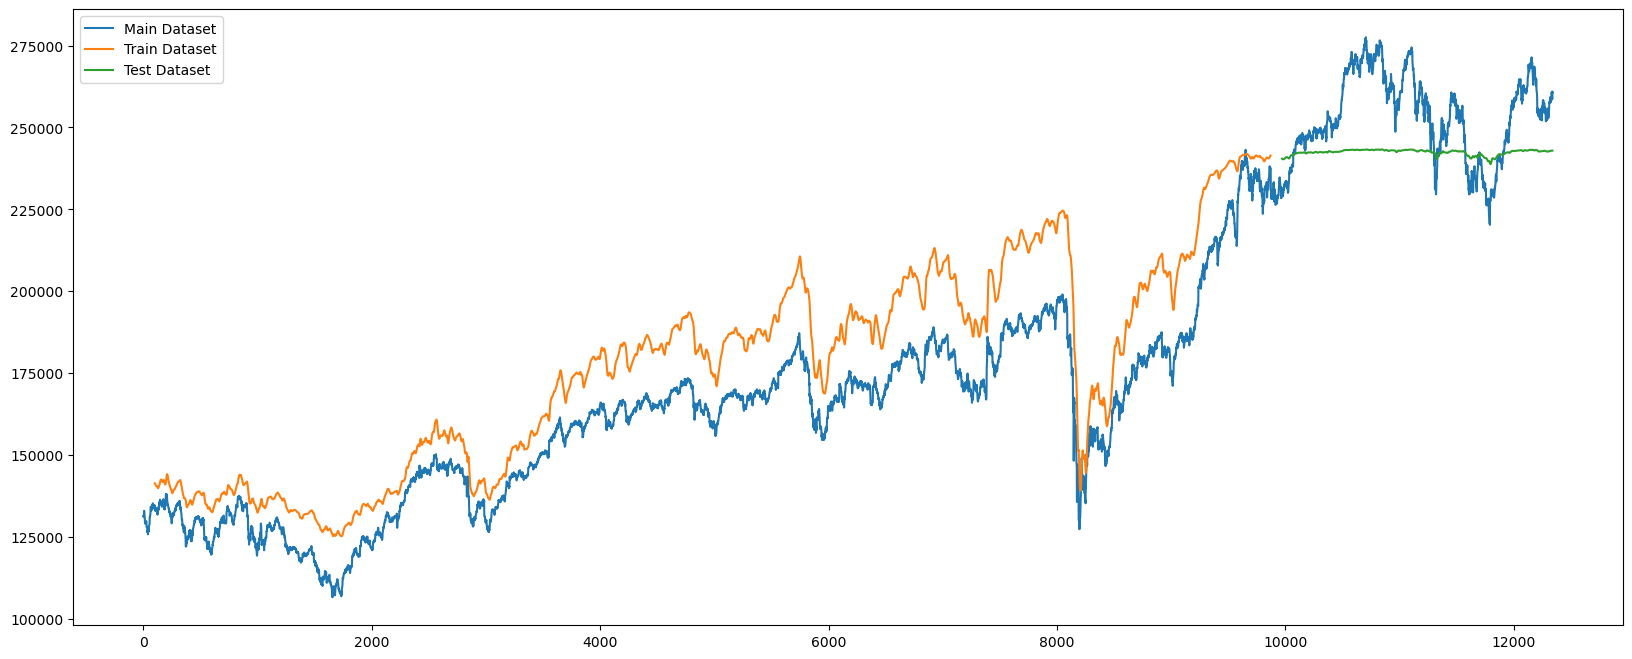

In [20]:
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(df1), label = 'Main Dataset')
plt.plot(trainPredictPlot, label = 'Train Dataset')
plt.plot(testPredictPlot, label = 'Test Dataset')
plt.legend()